# A Polygon $\rightarrow$ Normal Polygon Transformation Algorithm

Hi my name is Joseph Chai, a student at Princeton University. This is the associated codebase to my junior paper "A Polygonal Proof to the Isoperimetric Inequality"

This algorithm serves as a direct proof to the Isoperimetric Inequality for any n-sided polygon. We essentially take any n-sided polygon, $P_n$, and send it to a normal polygon, $\overline P_n$ under a rigorous molding process that conserves perimeter & maximizes area or vice versa in every iteration. This conservation allows us to increase the isoperimetric ratio (IR) of $P_n$ and show that the IR of $P_n$ converges to the IR of $\overline P_n$ (with the same starting perimeter or area as $P_n$).

In this algorithm we explore two main molding processes, one of which is "inferior" to the other. We use "inferior" here to denote the insufficiency of this algorithm to send any n-sided polygon to its normal polygon counterpart. Before introducing the two algorithms we first define their difference.

Triangle Symmetrization (def triangulation): this function takes in any set of vertices and essentially isoscelizes the triangle formed by one fixed triplet of consecutive vertices. This isoscelization process is repeated counterclockwise/clockwise (pick one) upon all the vertices. A "cycle" denotes the success of this isoscelization process applied on every vertex $v$ (you can think of $v$ as the center vertex of the triangle). As you will see below, this algorithm is inferior to Trapezoid-Triangle Fitting, as the convergent polygon has equal side lengths but not necessarily equal interior angles.

1. Trapezoid-Triangle Fitting with Triangle Symmetrization (def trapTriFitting(triangulation(vertices))): this function essentially uses triangle symmetrization and a small other function quadToTrapezoid. I encourage the reader at this point to read my paper if you'd like to see how this molding process works as the illustrations in the paper will be helpful for understanding.

2. Trapezoid_Triangle Fitting without Triangle Symmetrization (def trapTriFitting(vertices)): refer to paper in github (https://github.com/jchaitheguy/isoperimetric_inequalities/blob/main/A_Polygonal_Proof_to_the_Isoperimetric_Inequality.pdf).

Results: Using this algorithm we show that the convergence of $IR(P_n) \rightarrow IR(\overline P_N)$ indeed holds true $\forall n \in \mathbb{N}$. Furthermore, the convergence of 1) seems to always be faster than the convergence rate of 2) by just a little bit.




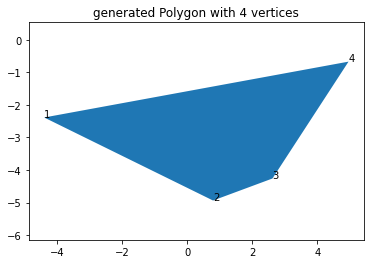

new_poly area: 18.856191566786826
normal 4-agon area: 1.2603466438787585
edge_lengths: [4.51074936837393, 4.51074936837393, 4.51074936837393, 4.51074936837393]


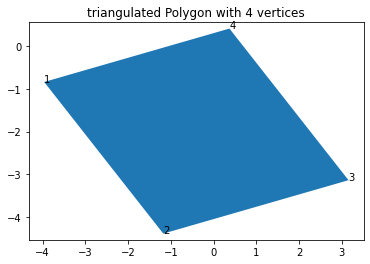

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from shapely import geometry

# check if a point is above a line
is_above = lambda p,a,b: np.cross(p-a, b-a) < 0

def generate_random_polygon(n, radius=5):
	"""Generates a random polygon with n vertices."""

	# Generate random angles
	angles = np.random.rand(n) * 2 * np.pi 

	# Convert angles to x, y coordinates
	x = radius * np.cos(angles)
	y = radius * np.sin(angles)

	# Sort vertices by angle to ensure a non-self-intersecting polygon
	vertices = np.stack((x, y), axis=1)
	vertices = vertices[np.argsort(angles)]
	return vertices


# Create figure and axes
def sketch_polygon(vertices, special_name=None):
	# for quadrilaterals only
	
	fig, ax = plt.subplots()
	# Define polygon parameters
	# Create the polygon patch
	polygon_sketch = Polygon(vertices)
	for i in range(len(vertices)):
		plt.annotate(i+1,vertices[i])
	# Add polygon to the plot
	ax.add_patch(polygon_sketch)

	plt.axis('equal')  # Ensure axes are scaled equally
	plt.title(f"{special_name} Polygon with {len(vertices)} vertices")
	plt.show()

# returns a new set of vertices representing the isosceles form of triangle with the same base
def make_isosceles(triangle):

	p1 = triangle[0]
	p2 = triangle[1]
	p3 = triangle[2]

	# Step 1: Compute the midpoint, height h, and line (s,y_0) that is perpendicular to the base
	midpoint = (p1 + p3) / 2

	perp_slope = -(p3[0]-p1[0])/(p3[1]-p1[1])
	height = np.abs(np.cross(p2-p3,p2-p1)/np.linalg.norm(p3-p1))

	# Step 2: Construct a vector height_vect with norm h, with slope s.
	height_vect_x = np.sqrt((height**2)/(1+(perp_slope**2)))
	height_vect_y = perp_slope*height_vect_x
	height_vect = [height_vect_x,height_vect_y]

	# Step 3: If original vertex was above the midpoint return new vertex pt = old v + height_vect, else return minus
	above_line = is_above(p2,p3,p1)
	if(p3[1]>p1[1]):
		if(above_line):
			triangle[1] = midpoint+height_vect 
		else:
			triangle[1] = midpoint-height_vect 
	else:
		if(above_line):
			triangle[1] = midpoint-height_vect 
		else:
			triangle[1] = midpoint+height_vect 

	return triangle

# iterates exactly n times for the first vertex
def triangulation(vertices):
	n = len(vertices)
	for i in range(n):
		# constructing the new isoscles
		triangle = [vertices[i], vertices[(i + 1) % n], vertices[(i + 2) % n]] 
		isosceles_triangle = make_isosceles(triangle)

		# replacing the old triangle with the new isosceles
		vertices[i] = list(isosceles_triangle[0])
		vertices[(i+1)%n] = list(isosceles_triangle[1])
		vertices[(i+2)%n] = list(isosceles_triangle[2])
	return vertices 

# need to double check of the normal n-agon area func is accurate
def perimeter(vertices):
	perimeter = 0
	for j in range(len(vertices)):
		perimeter += np.linalg.norm(vertices[(j+1)%len(vertices)]-vertices[j])
	return perimeter

def normal_poly_area(n,perimeter):
	return (np.power(perimeter,2))/(4*n*np.tan(np.pi/n))



def PolyArea(vertices):
    n = len(vertices)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += vertices[i][0] * vertices[j][1]
        area -= vertices[j][0] * vertices[i][1]
    area = abs(area) / 2.0
    return area


# measures the convergence rate for the first vertex
def measure_convergence(vertices, cycles):
	distances = [np.linalg.norm(vertices[0]-vertices[1])]
	perim = perimeter(vertices)
	n = len(vertices)
	for i in range(cycles):
		new_vertices = triangulation(vertices)
		distances.append(np.linalg.norm(new_vertices[0]-new_vertices[1]))
		vertices = new_vertices

	'''# plotting the length of the first edge after #cycles
	plt.plot(distances)
	#plt.axhline(y = perim/(len(vertices)), linestyle='--', color='red',label="Regular poly. side length")
	plt.title(f"Length of the first edge across {n} cycles")
	plt.xlabel("n cycles")
	plt.xticks(np.arange(0,cycles+1,1))
	plt.ylabel("Length")
	plt.legend()'''
	return vertices

# find the lengths of each edge
def edge_lengths(vertices):
	lengths = []
	for i in range(len(vertices)):
		lengths.append(np.abs(np.linalg.norm(vertices[(i+1)%len(vertices)]-vertices[i])))
	return lengths

## Example usage\

# number of vertices
n = 4
# we need a fix to send nonconvex polygons to convex by reflection
# generate n random vertices (convex polygon)
vertices = generate_random_polygon(n)
sketch_polygon(vertices, "generated")

# apply the triangulation cycle 30 times (each triangulation cycle makes 
# every triangle formed by three consecutive edges isosceles once in CCW)

new_poly = measure_convergence(vertices,30)
print("new_poly area:",PolyArea(new_poly))
print(f"normal {n}-agon area:",normal_poly_area(perimeter(new_poly),n))
print("edge_lengths:",edge_lengths(new_poly))
sketch_polygon(new_poly, "triangulated")



In [12]:
# fix vertices 2,3 adjust 1,4
# NEED TO DO SOME CASE SWITCHING WHEN 1-4 IS SMALLER THAN 2-3
# check if a point is above a line
def is_above_line(p,p1,p2):
	slope = (p2[1]-p1[1])/(p2[0]-p1[0])
	intercept = p1[1]-(slope*p1[0])
	theoretical_y = intercept+(slope*p[0])
	if(p[1]>=theoretical_y):
		return True
	else:
		return False
     
def quadToTrapezoid(vertices):

    p1 = vertices[0]
    p2 = vertices[1]
    p3 = vertices[2]
    p4 = vertices[3]

    right = np.abs(np.linalg.norm(p1-p2))
    left = np.abs(np.linalg.norm(p3-p4))
    l_bar = (right+left)/2
    #print("l_bar:",l_bar)
    top_base = np.abs(np.linalg.norm(p2-p3))
    bot_base = np.abs(np.linalg.norm(p1-p4))
    #print("top_base:",top_base)
    #print("bot_base:",bot_base)
    x_offset = (bot_base-top_base)/2
    h = np.sqrt(np.power(l_bar,2)-np.power(x_offset,2))
    h_squared = np.power(l_bar,2)-np.power(x_offset,2)

    # case switch when 1-4 is smaller than 2-3
    if(top_base<=bot_base):
        #print("case1")
        slope = (p3[1]-p2[1])/(p3[0]-p2[0])
        #print("slope:",slope)
        perp_slope = -1/slope
        x = np.sqrt(h_squared/(1+np.power(perp_slope,2)))
        y = perp_slope*x

        x2 = np.sqrt(np.power(x_offset,2)/(1+np.power(slope,2)))
        y2 = slope*x2
        '''print("x:",x)
        print("y:",y)
        print("x2:",x2)
        print("y2:",y2)
        print("p2:",p2)
        print("p3:",p3)'''

        if(is_above_line(p1,p2,p3)):
            new_p1 = [p2[0]+x, p2[1]+y]
            new_p4 = [p3[0]+x, p3[1]+y]
            #print(3)
        else:
            new_p1 = [p2[0]-x, p2[1]-y]
            new_p4 = [p3[0]-x, p3[1]-y]
            #print(4)

        intermediate_trap = np.array([new_p1,p2,p3,new_p4])

        if(is_above_line(new_p1,p2,p3)):
            final_p1 = [new_p1[0]-x2, new_p1[1]-y2]
            final_p4 = [new_p4[0]+x2, new_p4[1]+y2]
            #print(1)
        else:
            final_p1 = [new_p1[0]+x2, new_p1[1]+y2]
            final_p4 = [new_p4[0]-x2, new_p4[1]-y2]
            #print(2)

        '''print("measured_h:",np.abs(np.linalg.norm(new_p1-p2)))
        print("should_be_h:",np.sqrt(np.power(l_bar,2)-(np.power(x_offset,2))))
        print("new left:",np.abs(np.linalg.norm(new_p1-p2)))
        print("new right:",np.abs(np.linalg.norm(new_p4-p3)))'''
    
    else:
        #print("case2")
        #print("case1")
        slope = (p3[1]-p2[1])/(p3[0]-p2[0])
        #print("slope:",slope)
        perp_slope = -1/slope
        x = np.sqrt(h_squared/(1+np.power(perp_slope,2)))
        y = perp_slope*x

        x2 = np.sqrt(np.power(x_offset,2)/(1+np.power(slope,2)))
        y2 = slope*x2
        '''print("x:",x)
        print("y:",y)
        print("x2:",x2)
        print("y2:",y2)
        print("p2:",p2)
        print("p3:",p3)'''

        if(slope>0):
            if(is_above_line(p1,p2,p3)):
                new_p1 = [p2[0]-x, p2[1]-y]
                new_p4 = [p3[0]-x, p3[1]-y]
                #print(3)
            else:
                new_p1 = [p2[0]+x, p2[1]+y]
                new_p4 = [p3[0]+x, p3[1]+y]
                #print(4)
        else:
            if(is_above_line(p1,p2,p3)):
                new_p1 = [p2[0]+x, p2[1]+y]
                new_p4 = [p3[0]+x, p3[1]+y]
                #print(3)
            else:
                new_p1 = [p2[0]-x, p2[1]-y]
                new_p4 = [p3[0]-x, p3[1]-y]
                #print(4)
        intermediate_trap = np.array([new_p1,p2,p3,new_p4])

        if(is_above_line(new_p1,p2,p3)):
            final_p1 = [new_p1[0]+x2, new_p1[1]+y2]
            final_p4 = [new_p4[0]-x2, new_p4[1]-y2]
            #print(1)
        else:
            final_p1 = [new_p1[0]-x2, new_p1[1]-y2]
            final_p4 = [new_p4[0]+x2, new_p4[1]+y2]
            #print(2)

        '''print("measured_h:",np.abs(np.linalg.norm(new_p1-p2)))
        print("should_be_h:",np.sqrt(np.power(l_bar,2)-(np.power(x_offset,2))))
        print("new left:",np.abs(np.linalg.norm(new_p1-p2)))
        print("new right:",np.abs(np.linalg.norm(new_p4-p3)))'''

    return intermediate_trap, np.array([final_p1,p2,p3,final_p4])
     
n = 4
vertices = np.array([[2.56342465, -0.24180166], [5.22687551, 0.75146841], [0.72616785, 3.78204819], [0.02038101, 1.0284286 ]])

'''                                                
inter_trap, trapezoid = quadToTrapezoid(vertices)
print("vertices:",vertices)
print("inter_trap:",inter_trap)
print("trapezoid:",trapezoid)
print("p1:",trapezoid[0])
print("p2:",trapezoid[1])
print("p3:",trapezoid[2])
print("p4:",trapezoid[3])
sketch_polygon(vertices)
sketch_polygon(inter_trap)
sketch_polygon(trapezoid)
print("old perim:",perimeter(vertices))
print("new perim:",perimeter(trapezoid))
'''


'                                                \ninter_trap, trapezoid = quadToTrapezoid(vertices)\nprint("vertices:",vertices)\nprint("inter_trap:",inter_trap)\nprint("trapezoid:",trapezoid)\nprint("p1:",trapezoid[0])\nprint("p2:",trapezoid[1])\nprint("p3:",trapezoid[2])\nprint("p4:",trapezoid[3])\nsketch_polygon(vertices)\nsketch_polygon(inter_trap)\nsketch_polygon(trapezoid)\nprint("old perim:",perimeter(vertices))\nprint("new perim:",perimeter(trapezoid))\n'

In [13]:
# function that splits a polygon into triangles/quadrilaterals
import math
def sort_vertices(points):
   def key(x):
      atan = math.atan2(x[1], x[0])
      return (atan, x[1]**2+x[0]**2) if atan >= 0 else (2*math.pi + atan, x[0]**2+x[1]**2)

   return sorted(points, key=key)

def split_poly(vertices,start_vertex):
    n = len(vertices)
    polyies = []
    j = n
    # finding the indices of the polygon vertices
    while(j>=1):
        if(j==n):
            polyies.append([start_vertex,(start_vertex+1)%n,(start_vertex+2)%n])
            j -= 3
        else:
            start_node = polyies[-1][0]
            end_node = polyies[-1][-1]
            # case of the last triangle
            if((start_node-1)%n == (end_node+1)%n):
                new_poly = [start_node,end_node,(end_node+1)%n]
            else:
                new_poly = [(start_node-1)%n,start_node,end_node,(end_node+1)%n]
                
            polyies.append(new_poly)
            # subtracting only the added vertices
            j -= len(new_poly)-2

    # converting these indices into cartesian coordinates
    poly_coordinates = []
    for i in range(len(polyies)):
        current_poly = []
        for y in range(len(polyies[i])):
            current_poly.append(vertices[polyies[i][y]])
        poly_coordinates.append(current_poly)
    return poly_coordinates, polyies

'''# test
n = 5
vertices = generate_random_polygon(n)
print("vertices:",vertices)
sketch_polygon(vertices)

poly_coord, poly_indices = split_poly(vertices,0)
print(poly_indices)
print("poly_coord:",poly_coord)

for i in range(len(poly_indices)):
    sketch_polygon(poly_coord[i])'''

'# test\nn = 5\nvertices = generate_random_polygon(n)\nprint("vertices:",vertices)\nsketch_polygon(vertices)\n\npoly_coord, poly_indices = split_poly(vertices,0)\nprint(poly_indices)\nprint("poly_coord:",poly_coord)\n\nfor i in range(len(poly_indices)):\n    sketch_polygon(poly_coord[i])'

----------Starting Poly------------
start_poly: [[ 4.77130371  1.49487821]
 [-0.85424209  4.92648662]
 [-4.52303326 -2.13123677]
 [-0.68015682 -4.95352266]
 [ 2.21955692 -4.48035345]]
start_poly_perimeter: 28.747199016567407
start_poly_area: 54.28922104631766
start_poly_iso: 15.222201302042581


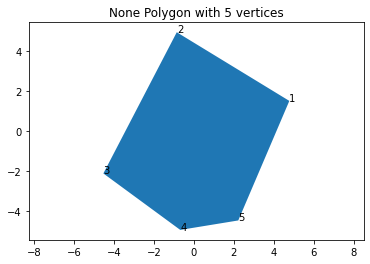

----------Trap_Tri Fitting Without Triangulation------------
ttFittedWithoutTriang: [array([3.05344879, 3.73044339]), array([-2.64590798,  4.06494457]), array([-4.72524309, -1.25216895]), array([-0.31100656, -4.87274866]), array([ 4.49653939, -1.79332781])]
ttFittedWithoutTriang_perimeter: 28.54591568098853
ttFittedWithoutTriang_area: 56.07856874386941
ttFittedWithoutTriang_iso: 14.530850560539484
ttFittedWithoutTriang_convergedIter: 9


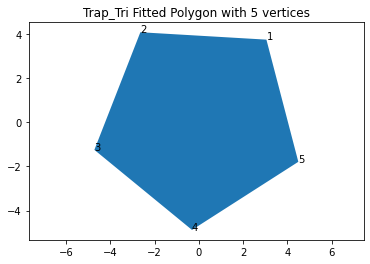

----------Trap_tri Fitting Poly with Triangulation------------
ttFittedWithTriang: [array([4.18661876, 2.55537632]), array([-0.98968956,  4.73876709]), array([-4.66579321,  0.49051744]), array([-1.76144257, -4.31844404]), array([ 3.70964432, -3.04228913])]
ttFittedWithTriang_perimeter: 28.08975039967023
ttFittedWithTriang_area: 54.30061194634571
ttFittedWithTriang_iso: 14.530850560126582
ttFittedWithTriang_convergedIter: 9


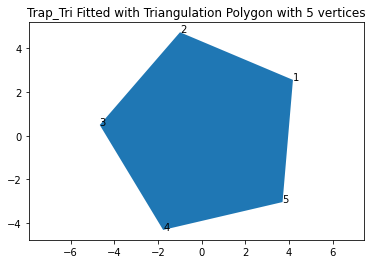

([<matplotlib.axis.XTick at 0x7f98092e9520>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

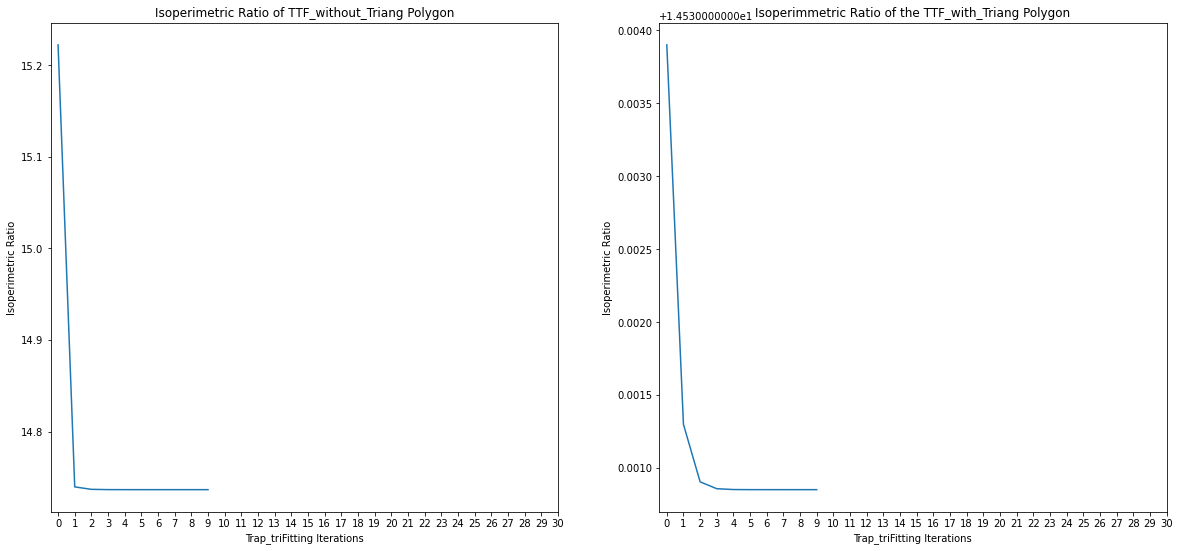

In [14]:

def isoperimetric_ratio(perim, area):
    return np.power(perim,2)/area;

# rotate through the vertices to split-> trapezoid/triangle fitting -> glue back together (currently just one cycle)
def trapTriFitting(vertices, iter):
    iter_converged = 0
    n = len(vertices)
    perim = perimeter(vertices)
    isoperimetric_ratios = [np.power(perim,2)/PolyArea(vertices)]
    # applying trap_tri fitting iter times
    for x in range(iter):
        for i in range(n):
            #print(f"-------------Fitting from {i}th vertex----------------")
            # Step 1: Partition Poly
            partitions, poly_indices = split_poly(vertices, i)
            
            # Step 2: Trapezoid/Triangle Fitting
            for j in range(len(partitions)):
                curr_par = partitions[j]
                #print("current_partition:",curr_par)
                #print("current_partition_perim:",perimeter(curr_par))

                #sketch_polygon(curr_par)

                if(len(curr_par)==3):
                    partitions[j] = make_isosceles(curr_par)
                else:
                    intertrap, trap = quadToTrapezoid(curr_par)
                    partitions[j] = trap
                # sketch partition
                #print("transformed_partition:",partitions[j])
                #print("transformed_partition_perim:",perimeter(partitions[j]))

                #sketch_polygon(partitions[j])

            # Step 3: Glue the transformed partitions
            transformed_poly = partitions[0]

            for k in range(len(partitions)):
                for h in range(len(partitions[k])):

                    curr_vertex = partitions[k][h]
                    is_in_list = np.any(np.all(curr_vertex == transformed_poly, axis=1))

                    if (is_in_list):
                        pass
                    else:
                        transformed_poly.append(curr_vertex)
            # Step 4: Sort the transformed vertices by angle (non-self intersecting polygon)
            transformed_vertices = sort_vertices(transformed_poly)
            #print(f"polygon after {i}th iteration")
            #sketch_polygon(transformed_vertices)

            # Set new poly
            vertices = transformed_vertices
            
        # store the area of the polygon after this iteration
        isoperimetric_ratios.append(np.power(perim,2)/PolyArea(vertices))

        # check for convergence
        tol = 10e-10

        if(np.abs(isoperimetric_ratios[-1]-isoperimetric_ratios[-2])<=tol):
            iter_converged = x+1
            return vertices, isoperimetric_ratios, iter_converged

    return vertices, isoperimetric_ratios, -1


# test
n = 5

# Build Poly with Triangulation
start_poly = generate_random_polygon(n)

triang_iter = 30
trap_tri_iter = 30

print("----------Starting Poly------------")

print("start_poly:",start_poly)
print("start_poly_perimeter:",perimeter(start_poly))
print("start_poly_area:",PolyArea(start_poly))
print("start_poly_iso:",isoperimetric_ratio(perimeter(start_poly),PolyArea(start_poly)))
sketch_polygon(start_poly)


print("----------Trap_Tri Fitting Without Triangulation------------")

ttFittedWithoutTriang, ttFittedWithoutTriang_ISO, ttFittedWithoutTriang_convergedIter = trapTriFitting(start_poly.copy(),trap_tri_iter)
print("ttFittedWithoutTriang:",ttFittedWithoutTriang)
print("ttFittedWithoutTriang_perimeter:",perimeter(ttFittedWithoutTriang))
print("ttFittedWithoutTriang_area:",PolyArea(ttFittedWithoutTriang))
print("ttFittedWithoutTriang_iso:",isoperimetric_ratio(perimeter(ttFittedWithoutTriang),PolyArea(ttFittedWithoutTriang)))
print("ttFittedWithoutTriang_convergedIter:",ttFittedWithoutTriang_convergedIter)
sketch_polygon(ttFittedWithoutTriang, "Trap_Tri Fitted")


print("----------Trap_tri Fitting Poly with Triangulation------------")

triang_poly = measure_convergence(start_poly.copy(),triang_iter)
ttFittedWithTriang, ttFittedWithTriang_ISO, ttFittedWithTriang_convergedIter = trapTriFitting(triang_poly,trap_tri_iter)
print("ttFittedWithTriang:",ttFittedWithTriang)
print("ttFittedWithTriang_perimeter:",perimeter(ttFittedWithTriang))
print("ttFittedWithTriang_area:",PolyArea(ttFittedWithTriang))
print("ttFittedWithTriang_iso:",isoperimetric_ratio(perimeter(ttFittedWithTriang), PolyArea(ttFittedWithTriang)))
print("ttFittedWithTriang_convergedIter:",ttFittedWithTriang_convergedIter)

sketch_polygon(ttFittedWithTriang, "Trap_Tri Fitted with Triangulation")


ratio_plot = plt.figure(figsize=[20,9])
# plotting area of polygon without triangulation headstart
plt.subplot(1,2,1)
plt.plot(ttFittedWithoutTriang_ISO)
plt.title(f"Isoperimetric Ratio of TTF_without_Triang Polygon")
plt.xlabel("Trap_triFitting Iterations")
plt.ylabel("Isoperimetric Ratio")
plt.xticks(np.arange(0,trap_tri_iter+1))

# plotting area of polygon with triangulation headstart
plt.subplot(1,2,2)
plt.plot(ttFittedWithTriang_ISO)
plt.title(f"Isoperimmetric Ratio of the TTF_with_Triang Polygon")
plt.xlabel("Trap_triFitting Iterations")
plt.ylabel("Isoperimetric Ratio")
plt.xticks(np.arange(0,trap_tri_iter+1))




Mean convergedIter_withoutTriang:  10.88

std convergedIter_withoutTriang:  1.3136209498938423

variance convergedIter_withoutTriang:  1.7256000000000002


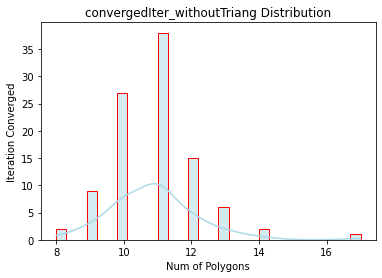


Mean convergedIter_withTriang:  10.26

std convergedIter_withTriang:  1.3756453031214113

variance convergedIter_withTriang:  1.8923999999999999


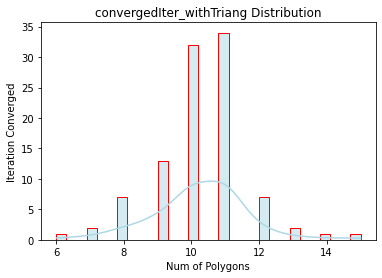

In [15]:
# probabilistic analysis
import seaborn as sns

'''
We run trapTriFitting(vertices,30) on 100 random polygons and 
return the normal distribution of the isoperimetric ratio (IR) converging marks for with 
Triangle Symmetrization vs. Without Triangle Symmetrization
Note: Here we are implicitly assuming for n = 5, the trap_tri fitting process and 
triangle symmetrization process for n-sided polygons converge within 30 iterations each
(this number should be adjusted accordingly for higher n)
'''

n = 5
triang_iter = 30
trap_tri_iter = 30
numOfPolygons = 100

convergedIter_withoutTriang = []
convergedIter_withTriang = []

# gather the converging iteration numbers
for i in range(numOfPolygons):

    polygon = generate_random_polygon(n)

    '''
    Case 1: Trap Tri Fitting without Triangulation
    Apply trap_tri_iter # of iterations of trapTriFitting (i.e. re-engineered Steiner Symmetrization)
    '''

    ttFittedWithoutTriang, ttFittedWithoutTriang_ISO, ttFittedWithoutTriang_convergedIter = trapTriFitting(polygon.copy(),trap_tri_iter)

    '''
    Case 2: Trap Tri Fitting with Triangulation
    First apply triang_iter # of iterations of Triangulation Symmetrization then apply 
    trap_tri_iter # of iterations of trapTriFitting (i.e. re-engineered Steiner Symmetrization)
    '''
    triang_poly = measure_convergence(polygon.copy(),triang_iter)
    ttFittedWithTriang, ttFittedWithTriang_ISO, ttFittedWithTriang_convergedIter = trapTriFitting(triang_poly,trap_tri_iter)

    # For this polygon, collect the converging iteration marks for Case 1 & 2 and add them into our database
    convergedIter_withoutTriang.append(ttFittedWithoutTriang_convergedIter)
    convergedIter_withTriang.append(ttFittedWithTriang_convergedIter)

# plot the normal distribution of the convergent iterations
r1 = np.mean(convergedIter_withoutTriang) 
print("\nMean convergedIter_withoutTriang: ", r1) 
r2 = np.std(convergedIter_withoutTriang) 
print("\nstd convergedIter_withoutTriang: ", r2) 
r3 = np.var(convergedIter_withoutTriang) 
print("\nvariance convergedIter_withoutTriang: ", r3)
sns.histplot(convergedIter_withoutTriang, bins=30, kde=True, color='lightblue', edgecolor='red')
plt.title("convergedIter_withoutTriang Distribution")
plt.xlabel("Num of Polygons")
plt.ylabel("Iteration Converged")
plt.show()



e1 = np.mean(convergedIter_withTriang) 
print("\nMean convergedIter_withTriang: ", e1) 
e2 = np.std(convergedIter_withTriang) 
print("\nstd convergedIter_withTriang: ", e2) 
e3 = np.var(convergedIter_withTriang) 
print("\nvariance convergedIter_withTriang: ", e3)
sns.histplot(convergedIter_withTriang, bins=30, kde=True, color='lightblue', edgecolor='red')
plt.title("convergedIter_withTriang Distribution")
plt.xlabel("Num of Polygons")
plt.ylabel("Iteration Converged")
plt.show()